In [25]:
import bambi as bmb
import pandas as pd
import pymc3 as pm
import pymc3.diagnostics as pmd
import numpy as np
from scipy.stats import norm
import pylab
import seaborn as sns
import re
%matplotlib inline

# Load and examine Eugene-Springfield community sample data

In [95]:
data = pd.read_csv('data/ESCS.csv')
np.round(data.describe(), 2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


It's always a good idea to start off with some basic plotting. Here's what our outcome variable 'drugs' (some index of self-reported illegal drug use) looks like:

//anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


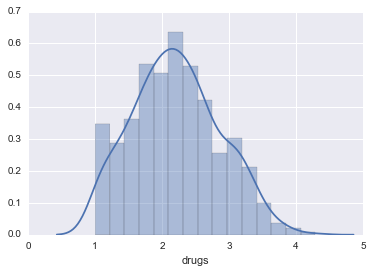

In [6]:
sns.distplot(data['drugs'])

The five predictor variables that we'll use are sum-scores measuring participants' standings on the Big Five personality dimensions. The dimensions are:
- O = Openness to experience
- C = Conscientiousness
- E = Extraversion
- A = Agreeableness
- N = Neuroticism

Here's what our predictors look like:

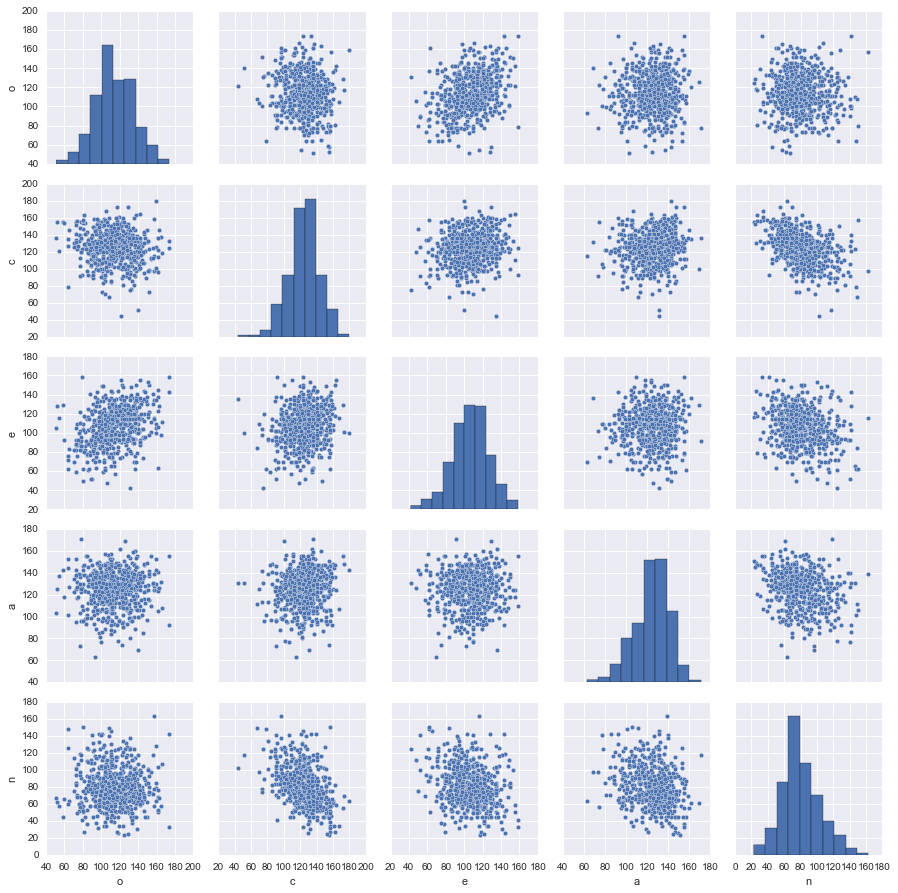

In [7]:
sns.pairplot(data[['o','c','e','a','n']])

# Specify model and examine priors

We're going to fit a pretty straightforward multiple regression model predicting drug use from all 5 personality dimension scores. It's simple to specify the model using a familiar formula interface:

In [3]:
model = bmb.Model(data)
model.add_formula('drugs ~ o + c + e + a + n')
model.build()

Applied log-transform to likelihood_sd and added transformed likelihood_sd_log to model.


Great! But this is a Bayesian model, right? What about the priors?

If no priors are given explicitly by the user, then bambi chooses smart default priors for all parameters of the model based on the implied partial correlations between the outcome and the predictors. Here's what the default priors look like in this case:

In [71]:
{x.name:x.prior.args for x in model.terms.values()}

{'Intercept': {'mu': 2.2101466414380631, 'sd': 4.9971880692479509},
 'a': {'mu': 0, 'sd': array([[ 0.02174207]])},
 'c': {'mu': 0, 'sd': array([[ 0.02169516]])},
 'e': {'mu': 0, 'sd': array([[ 0.01924664]])},
 'n': {'mu': 0, 'sd': array([[ 0.0177182]])},
 'o': {'mu': 0, 'sd': array([[ 0.01789335]])}}

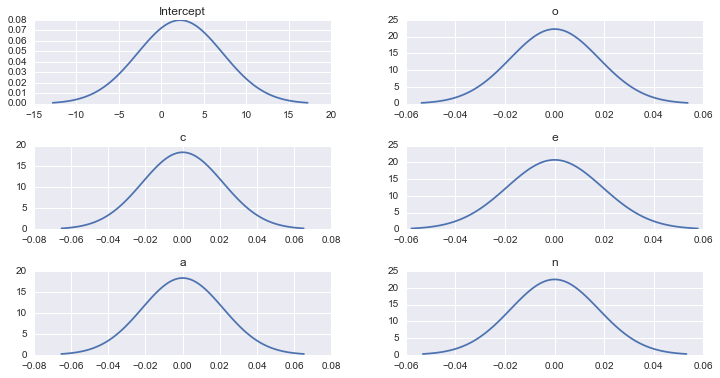

In [69]:
p = len(model.terms)
fig, axes = plt.subplots(int(np.ceil(p/2)), 2, figsize=(12,np.ceil(p/2)*2))

for i,t in enumerate(model.terms.values()):
    m = t.prior.args['mu']
    sd = np.asscalar(t.prior.args['sd'])
    x = np.linspace(m - 3*sd, m + 3*sd, 100)
    y = norm.pdf(x, loc=m, scale=sd)
    axes[divmod(i,2)[0], divmod(i,2)[1]].plot(x,y)
    axes[divmod(i,2)[0], divmod(i,2)[1]].set_title(t.name)
plt.subplots_adjust(wspace=.25, hspace=.5)

Notice the small SDs of the slope priors. This is due to the relative scales of the outcome and the predictors: remember from the plots above that the outcome, `drugs`, ranges from 1 to about 4, while the predictors all range from about 20 to 180 or so. So a one-unit change in any of the predictors -- which is a trivial increase on the scale of the predictors -- is likely to lead to a very small absolute change in the outcome. Believe it or not, these priors are actually quite wide on the partial correlation scale!

# Fit model and examine results

We haven't actually fit the model yet, we've just specified and 'built' the model, which essentially prepares the model for fitting. Let's now fit it!

In [80]:
fitted = model.fit(samples=2000, njobs=2)

Assigned NUTS to b_Intercept
Assigned NUTS to b_o
Assigned NUTS to b_c
Assigned NUTS to b_e
Assigned NUTS to b_a
Assigned NUTS to b_n
Assigned NUTS to likelihood_sd_log
 [-----------------100%-----------------] 2000 of 2000 complete in 59.1 sec

We actually could have specified and fit the model in a single line of code, which would have looked like:

In [ ]:
fitted = bmb.Model(data).fit('drugs ~ o + c + e + a + n', samples=2000, njobs=2)

Now we're ready to look at pretty pictures of the results!

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


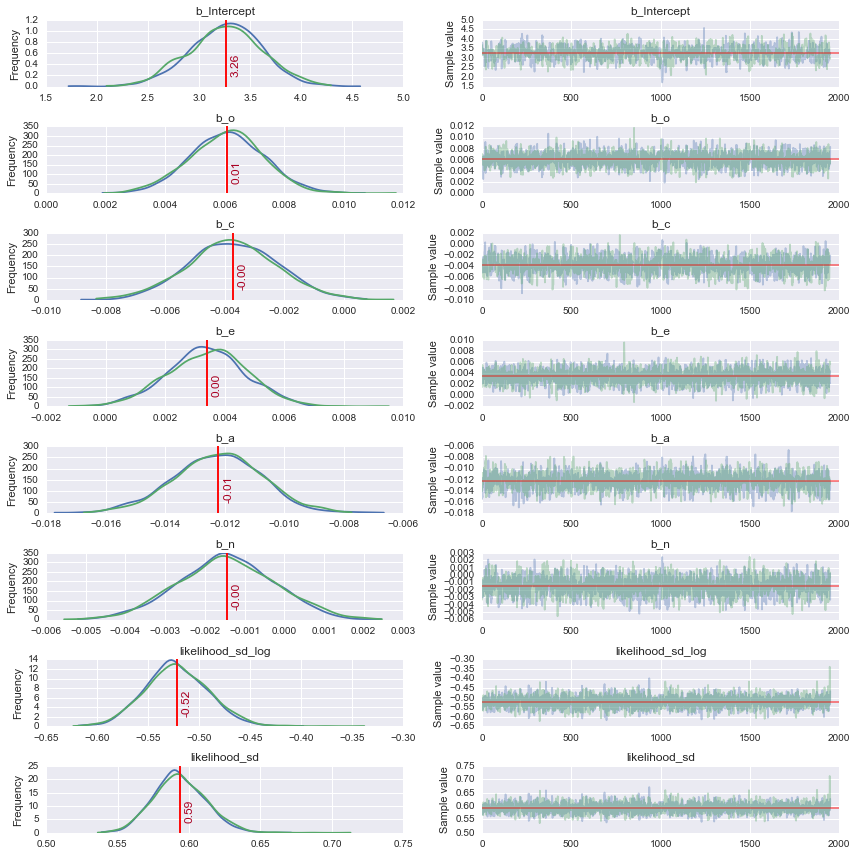

In [83]:
burn = 50
_ = fitted.plot(burn_in=burn)

# Diagnostics

The effective number of independent samples for each parameter are:

In [84]:
pmd.effective_n(fitted.trace[burn:])

{'b_Intercept': [772],
 'b_a': [1436],
 'b_c': [1232],
 'b_e': [2489],
 'b_n': [1491],
 'b_o': [2104],
 'likelihood_sd': 2866,
 'likelihood_sd_log': 2978}

And the Gelman-Rubin statistics (we want these to be close to 1) for each parameter are:

In [85]:
pmd.gelman_rubin(fitted.trace[burn:])

{'b_Intercept': array(0.9998086925136229),
 'b_a': array(1.000990374256969),
 'b_c': array(1.0003838230198123),
 'b_e': array(1.0002991833305337),
 'b_n': array(0.9999412817810559),
 'b_o': array(1.0001786951472096),
 'likelihood_sd': 1.0004971235555011,
 'likelihood_sd_log': 1.0004558362745766}

# Summarize effects on partial correlation scale

Let's grab the samples and put them in a format where we can easily work with them. Here we drop the first 50 samples from both of the chains, then combine all the remaining samples in a pandas DataFrame.

In [87]:
n_chains = 2
n_samples = 2000
preds = ['o','c','e','a','n']
traces = pd.DataFrame({x: fitted.trace['b_'+x].reshape(n_samples,n_chains)[burn:,:].flatten()
                       for x in preds})
traces.head()

,a,c,e,n,o
0,-0.013877,0.000053,0.003025,-0.001573,0.006553
1,-0.011362,-0.003561,0.002097,-0.000079,0.008497
2,-0.014488,-0.005469,0.004616,-0.003762,0.005412
3,-0.013727,-0.004793,0.003494,-0.002957,0.005578
4,-0.012760,-0.004970,0.003253,-0.003222,0.006573


It turns out that we can convert each regresson coefficient into a partial correlation by multiplying it by a constant that depends on (1) the SD of the predictor, (2) the SD of the outcome, and (3) the degree of multicollinearity with the set of other predictors. It further turns out that we already compute and store all the needed statistics in the fitted model object, in a dictionary called `dm_statistics` (for design matrix statistics)!

In [8]:
slope_constant = model.dm_statistics['sd_x'] * (1 - model.dm_statistics['r2_x']) / \
    model.dm_statistics['sd_y'] / (1 - model.dm_statistics['r2_y'])
slope_constant

a    26.554524
c    26.611936
e    29.997453
n    32.585149
o    32.266198
dtype: float64

Now we just multiply each sampled regression coefficient by its corresponding `slope_constant` to transform it into a sampled partial correlation coefficient.

In [88]:
pcorr_traces = pd.DataFrame({x: traces[x] * slope_constant[x] for x in preds})
pcorr_traces.head()

,a,c,e,n,o
0,-0.368496,0.001416,0.090746,-0.051268,0.211430
1,-0.301721,-0.094778,0.062895,-0.002563,0.274180
2,-0.384720,-0.145534,0.138462,-0.122600,0.174633
3,-0.364518,-0.127551,0.104810,-0.096345,0.179987
4,-0.338826,-0.132258,0.097590,-0.104973,0.212097


And voilà! We now have a joint posterior distribution for the partial correlation coefficients. Let's plot the marginal posterior distributions:

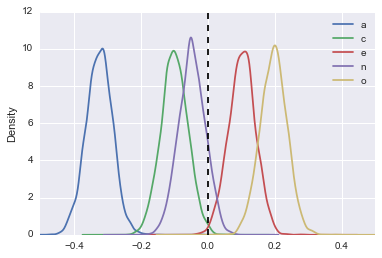

In [89]:
pcorr_traces.plot.kde(xlim=[-.5,.5]).axvline(x=0, color='k', linestyle='--')

The means of these distributions serve as good point estimates of the partial correlations:

In [90]:
pcorr_traces.mean(axis=0).sort_values()

a   -0.324424
c   -0.099625
n   -0.047587
e    0.101989
o    0.196152
dtype: float64

Naturally, these results are consistent with the OLS results. For example, we can see that these estimated partial correlations are roughly proportional to the t-statistics from the corresponding OLS regression:

In [128]:
pd.stats.api.ols(y=data['drugs'], x=data[['o','c','e','a','n']])


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <o> + <c> + <e> + <a> + <n> + <intercept>

Number of Observations:         604
Number of Degrees of Freedom:   6

R-squared:         0.1760
Adj R-squared:     0.1691

Rmse:              0.5914

F-stat (5, 598):    25.5432, p-value:     0.0000

Degrees of Freedom: model 5, resid 598

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             o     0.0061     0.0012       4.89     0.0000     0.0036     0.0085
             c    -0.0038     0.0015      -2.59     0.0098    -0.0067    -0.0009
             e     0.0034     0.0013       2.52     0.0120     0.0007     0.0060
             a    -0.0124     0.0015      -8.39     0.0000    -0.0153    -0.0095
             n    -0.0015     0.0012      -1.27     0

# Relative importance: Which predictors have the strongest effects (defined in terms of partial $\eta^2$)?

The partial $\eta^2$ statistics for each predictor are just the squares of the partial correlation coefficients, so it's easy to get posteriors on that scale too:

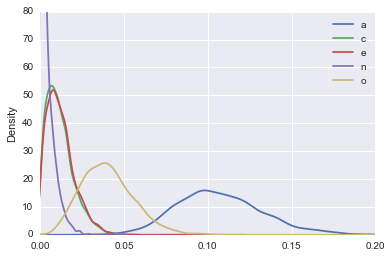

In [91]:
(pcorr_traces**2).plot.kde(xlim=[0,.2], ylim=[0,80])

With these posteriors we can ask: What is the probability that the partial $\eta^2$ for Openness (yellow) is greater than the partial $\eta^2$ for Conscientiousness (green)?

In [92]:
(pcorr_traces['o']**2 > pcorr_traces['c']**2).mean()

0.94128205128205134

For each predictor, what is the probability that it has the largest $\eta^2$?

In [93]:
(pcorr_traces**2).idxmax(axis=1).value_counts() / len(pcorr_traces.index)

a    0.986410
o    0.013077
e    0.000513
dtype: float64

Agreeableness is clearly the strongest predictor of drug use among the Big Five personality traits, but it's still not a particularly strong predictor in an absolute sense. Walter Mischel famously claimed that it is rare to see correlations between personality measurse and relevant behavioral outcomes exceed 0.3. In this case, the probability that the agreeableness partial correlation exceeds 0.3 is:

In [94]:
(pcorr_traces['a'] < -.3).mean()

0.7335897435897436